In [2]:
import pandas as pd
import numpy as np
import random
import torch
import json
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [3]:
from types import SimpleNamespace

# Define your parameters as a dictionary
parameters_dict = {
    "subjects": '경제', # 수학Ⅰ,수학Ⅱ
    "num_problems": 10,
    'set_type':['EC040003','EC040014'],
    "seed": 42,
    "original_data_path": '/root/jw/TAPTAP_IRT/data/full_data',
    "same_standard":  'middle_category',  
    "IQR_range": 1.5
}

def set_seed(seed):
    random.seed(seed)  
    np.random.seed(seed)  
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  

# Convert dictionary to SimpleNamespace
parameters = SimpleNamespace(**parameters_dict)
set_seed(parameters.seed)
subject_mapping_dict = {"통합과학":"Science","통합사회":"Humanities","수학Ⅰ,수학Ⅱ":'Math',"독해,듣기":'English',"독서,문학":"Korean","한국사":"Korean History", "생활과 윤리":"Life N Ethics", "정치와 법":"Politics N Law", "한국지리":"Korean Geo.", "세계지리":"World Geo.", "사회?문화":"Life Culture", "동아시아사":"East Asian History", "세계사":"World History", "윤리와 사상":"Ethical Philosopy", "경제":"Economics",
 "물리학Ⅰ":"PhysicsⅠ", "화학Ⅰ":"ChemistryⅠ", "생명과학Ⅰ":"BiologyⅠ", "지구과학Ⅰ":"Earth ScienceⅠ", "지구과학Ⅱ":"Earth ScienceⅡ", "생명과학Ⅱ":"BiologyⅡ", "화학Ⅱ":"ChemistryⅡ", "물리학Ⅱ":"PhysicsⅡ"}


In [4]:
###### import original datasets
# code: codename,  {1:국어}
category = pd.read_csv(f'{parameters.original_data_path}/perfectexam_category_202404031323.csv', encoding='cp949')
problem = pd.read_csv(f'{parameters.original_data_path}/perfectexam_problem_202404031323.csv', encoding='cp949')
member_exam_answer = pd.read_csv(f'{parameters.original_data_path}/perfectexam_member_exam_answer_202404031323.csv', encoding='cp949')
member_exam = pd.read_csv(f'{parameters.original_data_path}/perfectexam_member_exam_202404031323.csv', encoding='cp949')
exam_in_range = pd.read_csv(f'{parameters.original_data_path}/perfectexam_exam_202404031323.csv', encoding='cp949')

category_simple = category[['code', 'code_name']]
problem_simple = problem[['seq', 'subject', 'big_category', 'middle_category','small_category','point','answer_rate',"set_type", "ref_num"]]
member_exam_answer_simple = member_exam_answer[['member_idx', 'member_exam_seq', 'problem_seq', 'answer_dttm','correct_yn']]
member_exam_simple = member_exam[['seq', 'exam_seq', 'title']]
first_merge = member_exam_answer_simple.merge(member_exam_simple, left_on='member_exam_seq', right_on='seq', how='left').drop(columns='seq')
second_merge = first_merge[first_merge['exam_seq'].isin(exam_in_range['seq'])]
third_merge = second_merge.merge(exam_in_range[['seq', 'title']], left_on='exam_seq', right_on='seq', how='left').drop(columns=['seq', 'exam_seq', 'title_x'])
member_exam_answer_in_range = third_merge.merge(problem_simple, left_on='problem_seq', right_on='seq', how='left').drop(columns='seq')
category_dict = pd.Series(category_simple['code_name'].values, index=category_simple['code']).to_dict()
for column in ['subject', 'big_category', 'middle_category','small_category']:
    member_exam_answer_in_range[column] = member_exam_answer_in_range[column].map(category_dict)

###### filter by subjects
subjects_list = parameters.subjects.split(',')
print('subjects_list',subjects_list)
filtered_data = member_exam_answer_in_range[member_exam_answer_in_range['subject'].isin(subjects_list)]
filtered_data.shape

subjects_list ['경제']


(1842, 14)

## Calculate correct_rate by tatap data

In [5]:
import json 
response_count= pd.read_csv(f'../detailed/10_{parameters.subjects}_answer_count_taptap.csv', encoding='utf-8')
def calculate_probability(summary):
    parts = summary.split(', ')
    count_0 = int(parts[0].split(':')[1])
    count_1 = int(parts[1].split(':')[1])
    total = count_0 + count_1
    probability = round((count_1 / total)*100,1)
    return probability

response_count['probability'] = response_count['response_summary'].apply(calculate_probability)

print(response_count)


   problem_seq response_summary  probability
0        10095        0:9, 1:25         73.5
1        10096     0:129, 1:221         63.1
2        10098       0:17, 1:16         48.5
3        10102       0:18, 1:74         80.4
4        10104       0:19, 1:24         55.8
5        10107       0:12, 1:15         55.6
6        31335        0:9, 1:13         59.1
7        31612       0:19, 1:26         57.8
8        36639       0:22, 1:36         62.1
9        36642       0:13, 1:48         78.7


In [6]:
response_count

,problem_seq,response_summary,probability
0,10095,"0:9, 1:25",73.5
1,10096,"0:129, 1:221",63.1
2,10098,"0:17, 1:16",48.5
3,10102,"0:18, 1:74",80.4
4,10104,"0:19, 1:24",55.8
5,10107,"0:12, 1:15",55.6
6,31335,"0:9, 1:13",59.1
7,31612,"0:19, 1:26",57.8
8,36639,"0:22, 1:36",62.1
9,36642,"0:13, 1:48",78.7


In [7]:
problem_seq_keys = list(map(int, response_count['problem_seq']))
filtered_problems = problem[problem['seq'].isin(problem_seq_keys)]

max_points = filtered_problems.groupby('seq')['point'].max()

if 'max_point' in response_count.columns:
    response_count = response_count.rename(columns={'max_point': 'existing_max_point'})

# Merge the max_points DataFrame with the response_count DataFrame
response_count = response_count.merge(max_points, left_on='problem_seq', right_on='seq', how='left')

# Drop the unnecessary columns
columns_to_drop = ['seq_x', 'max_point_x', 'seq_y', 'max_point_y', 'existing_max_point']
response_count_taptap_df = response_count.drop(columns=[col for col in columns_to_drop if col in response_count.columns])

print(response_count_taptap_df)


   problem_seq response_summary  probability  point
0        10095        0:9, 1:25         73.5      2
1        10096     0:129, 1:221         63.1      3
2        10098       0:17, 1:16         48.5      3
3        10102       0:18, 1:74         80.4      3
4        10104       0:19, 1:24         55.8      2
5        10107       0:12, 1:15         55.6      3
6        31335        0:9, 1:13         59.1      2
7        31612       0:19, 1:26         57.8      3
8        36639       0:22, 1:36         62.1      2
9        36642       0:13, 1:48         78.7      2


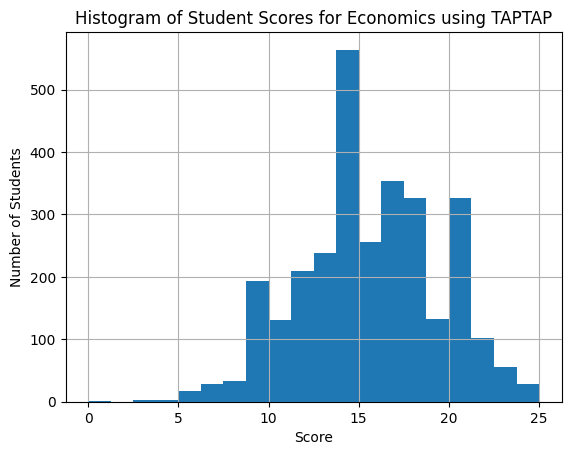

(14.0, 17.0)

In [75]:
# Number of students
num_students = 3000
students_scores = pd.DataFrame(index=range(num_students), columns=['score'])
correct_rate_taptap = response_count_taptap_df['probability']
points = response_count_taptap_df['point']

score_list_taptapp = []
# Run the simulation
for i in range(num_students):
    # Simulate student answers (1 for correct, 0 for incorrect) using Bernoulli distribution
    correct_answers = np.random.binomial(1, response_count_taptap_df['probability'] / 100)
    target_score = sum(r * d for r, d in zip(correct_answers, points))
    # Initialize inconsistency count
    inconsistency_count = 0
    total_possible_inconsistencies = 0
    # Iterate over all pairs of questions
    for i in range(len(points)):
        for j in range(i + 1, len(points)):
            if points[i] < points[j]:
                total_possible_inconsistencies += 1
                if correct_answers[i] == 0 and correct_answers[j] == 1:
                    inconsistency_count += 1
            elif points[i] > points[j]:
                total_possible_inconsistencies += 1
                if correct_answers[i] == 1 and correct_answers[j] == 0:
                    inconsistency_count += 1

    # Calculate inconsistency rate
    if total_possible_inconsistencies > 0:
        inconsistency_rate = inconsistency_count / total_possible_inconsistencies
    else:
        inconsistency_rate = 0

    # Parameters for adjusted penalty
    penalty_strength = 0.3    # Maximum penalty reduction
    penalty_threshold = 0.2   # Threshold above which penalty starts
    alpha = 2                 # Controls sensitivity to inconsistency increases

    # Apply adjusted penalty
    if inconsistency_rate <= penalty_threshold:
        penalty_factor = 1  
    else:
        normalized_inconsistency = (inconsistency_rate - penalty_threshold) / (1 - penalty_threshold)
        penalty_factor = 1 - penalty_strength * (normalized_inconsistency) ** alpha
        penalty_factor = max(penalty_factor, 1 - penalty_strength)

    target_score *= penalty_factor
    ################
    score_list_taptapp.append(target_score)


score_series = pd.Series(score_list_taptapp)
# Generate the histogram of student scores
score_series.hist(bins=20)
plt.xlabel('Score')
plt.ylabel('Number of Students')
plt.title(f'Histogram of Student Scores for {subject_mapping_dict[parameters.subjects]} using TAPTAP prob.')
plt.show()

# Calculate the score thresholds for the top 30% and 60%
threshold_33 = score_series.quantile(0.33)  # Bottom 33%
threshold_66 = score_series.quantile(0.66)  # Top 66%

threshold_33, threshold_66


## Use given correct_rate

In [77]:
# Create the final dictionary
answer_rate_dict = {str(row['seq']): [row['answer_rate'], row['point']] for _, row in filtered_problems.iterrows()} # {'36639': [82.0, 2], '36642': [89.0, 2], ...}
# first is 맞을 확률, second is 배점
print(answer_rate_dict)

{'36639': [82.0, 2], '36642': [89.0, 2], '31612': [81.0, 3], '31335': [95.0, 2], '10095': [79.0, 2], '10096': [86.0, 3], '10098': [66.0, 3], '10102': [61.0, 3], '10104': [66.0, 2], '10107': [31.0, 3]}


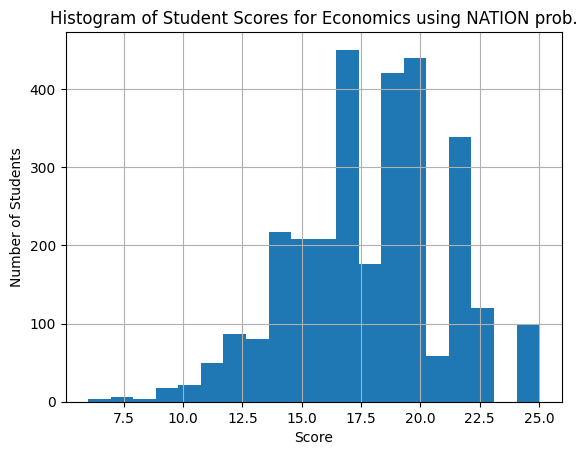

(17.0, 20.0)

In [92]:
num_students = 3000
students_scores = pd.DataFrame(index=range(num_students), columns=['score'])
correct_rate_nation = [value[0] for value in answer_rate_dict.values()]
points = [value[1] for value in answer_rate_dict.values()]

score_list_nation = []
# Run the simulation
for i in range(num_students):
    # Simulate student answers (1 for correct, 0 for incorrect) using Bernoulli distribution
    correct_answers = [np.random.binomial(1, rate / 100) for rate in correct_rate_nation]
    target_score = sum(r * d for r, d in zip(correct_answers, points))
    # Initialize inconsistency count
    inconsistency_count = 0
    total_possible_inconsistencies = 0
    # Iterate over all pairs of questions
    for i in range(len(points)):
        for j in range(i + 1, len(points)):
            if points[i] < points[j]:
                total_possible_inconsistencies += 1
                if correct_answers[i] == 0 and correct_answers[j] == 1:
                    inconsistency_count += 1
            elif points[i] > points[j]:
                total_possible_inconsistencies += 1
                if correct_answers[i] == 1 and correct_answers[j] == 0:
                    inconsistency_count += 1
    # Calculate inconsistency rate
    if total_possible_inconsistencies > 0:
        inconsistency_rate = inconsistency_count / total_possible_inconsistencies
    else:
        inconsistency_rate = 0
    # Parameters for adjusted penalty
    penalty_strength = 0.3    # Maximum penalty reduction
    penalty_threshold = 0.2   # Threshold above which penalty starts
    alpha = 2                 # Controls sensitivity to inconsistency increases
    # Apply adjusted penalty
    if inconsistency_rate <= penalty_threshold:
        penalty_factor = 1  
    else:
        normalized_inconsistency = (inconsistency_rate - penalty_threshold) / (1 - penalty_threshold)
        penalty_factor = 1 - penalty_strength * (normalized_inconsistency) ** alpha
        penalty_factor = max(penalty_factor, 1 - penalty_strength)

    target_score *= penalty_factor
    ################
    score_list_nation.append(target_score)

score_series = pd.Series(score_list_nation)
# Generate the histogram of student scores
score_series.hist(bins=20)
plt.xlabel('Score')
plt.ylabel('Number of Students')
plt.title(f'Histogram of Student Scores for {subject_mapping_dict[parameters.subjects]} using NATION prob.')
plt.show()

# Calculate the score thresholds for the top 30% and 60%
threshold_33 = score_series.quantile(0.33)  # Bottom 33%
threshold_66 = score_series.quantile(0.66)  # Top 66%

threshold_33, threshold_66